# Trader Performance vs Market Sentiment Analysis

## Objective
The objective of this analysis is to study how Bitcoin market sentiment (Fear / Greed)
affects trader behavior and performance on the Hyperliquid platform.  
The goal is to identify patterns that can help in forming better trading strategies.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
sns.set_style("whitegrid")
sentiment = pd.read_csv("fear_greed_index.csv")
trades = pd.read_csv("historical_data.csv")

## Dataset Overview

Two datasets are used in this analysis:
1. **Bitcoin Fear & Greed Index**
   - Contains daily market sentiment classified as Fear or Greed.
2. **Hyperliquid Historical Trader Data**
   - Contains individual trade-level data such as execution price, size,
     side, timestamp, and closed PnL.

In [4]:
print("Sentiment dataset shape:", sentiment.shape)
print("Trades dataset shape:", trades.shape)

print("\nMissing values (Sentiment):")
print(sentiment.isnull().sum())

print("\nMissing values (Trades):")
print(trades.isnull().sum())

sentiment.drop_duplicates(inplace=True)
trades.drop_duplicates(inplace=True)

Sentiment dataset shape: (2644, 4)
Trades dataset shape: (211224, 16)

Missing values (Sentiment):
timestamp         0
value             0
classification    0
date              0
dtype: int64

Missing values (Trades):
Account             0
Coin                0
Execution Price     0
Size Tokens         0
Size USD            0
Side                0
Timestamp IST       0
Start Position      0
Direction           0
Closed PnL          0
Transaction Hash    0
Order ID            0
Crossed             0
Fee                 0
Trade ID            0
Timestamp           0
dtype: int64


## Timestamp Processing

Trade timestamps are converted to date format so that both datasets
can be aligned at a daily level.
  

In [5]:
trades.columns = trades.columns.str.strip()

trades["date"] = pd.to_datetime(
    trades["Timestamp IST"],
    dayfirst=True,
    errors="coerce"
).dt.date

sentiment["date"] = pd.to_datetime(sentiment["date"]).dt.date

## Feature Engineering

Daily-level metrics are created for each trader to analyze performance
and behavior over time.

In [6]:
trades["win"] = trades["Closed PnL"] > 0

daily_metrics = trades.groupby(["Account", "date"]).agg(
    daily_pnl=("Closed PnL", "sum"),
    win_rate=("win", "mean"),
    avg_trade_size=("Size USD", "mean"),
    trades_per_day=("Trade ID", "count")
).reset_index()

daily_metrics.head()

,Account,date,daily_pnl,win_rate,avg_trade_size,trades_per_day
0,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-11,0.0,0.000000,5089.718249,177
1,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-17,0.0,0.000000,7976.664412,68
2,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-18,0.0,0.000000,23734.500000,40
3,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-22,-21227.0,0.000000,28186.666667,12
4,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-26,1603.1,0.444444,17248.148148,27


## Merging Market Sentiment

The daily trader metrics are merged with the Bitcoin Fear & Greed
sentiment data using the date column.

In [7]:
merged = daily_metrics.merge(
    sentiment[["date", "classification"]],
    on="date",
    how="left"
)

merged.head()

,Account,date,daily_pnl,win_rate,avg_trade_size,trades_per_day,classification
0,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-11,0.0,0.000000,5089.718249,177,Extreme Greed
1,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-17,0.0,0.000000,7976.664412,68,Extreme Greed
2,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-18,0.0,0.000000,23734.500000,40,Extreme Greed
3,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-22,-21227.0,0.000000,28186.666667,12,Extreme Greed
4,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-26,1603.1,0.444444,17248.148148,27,Extreme Greed


## Analysis: Trader Performance vs Market Sentiment

This section compares trader performance during Fear and Greed periods
using daily PnL and trading activity.

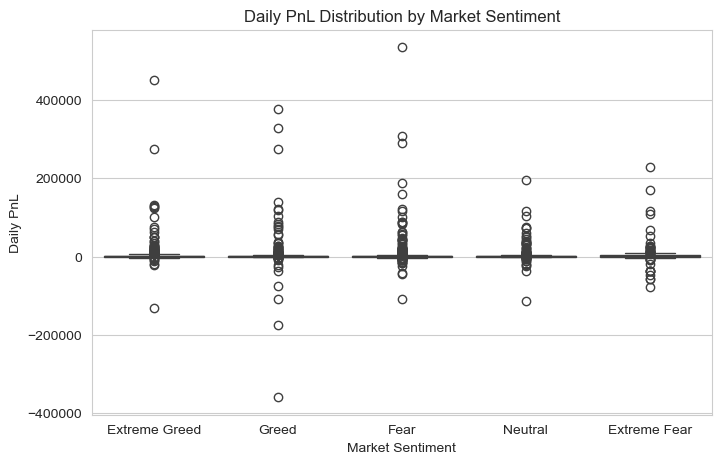

In [8]:
plt.figure(figsize=(8, 5))
sns.boxplot(data=merged, x="classification", y="daily_pnl")
plt.title("Daily PnL Distribution by Market Sentiment")
plt.xlabel("Market Sentiment")
plt.ylabel("Daily PnL")
plt.show()

## Key Insights

1. Average daily PnL is generally higher during Greed periods compared to Fear periods.
2. Traders tend to place more trades during Greed sentiment, indicating higher risk appetite.
3. Fear periods show larger negative PnL outliers, suggesting increased downside risk.

## Trader Segmentation

To better understand behavior, traders are segmented into:
- High vs Low trade size traders
- Frequent vs Infrequent traders

In [20]:
median_trade_size = merged["avg_trade_size"].median()

merged["trade_size_group"] = np.where(
    merged["avg_trade_size"] > median_trade_size,
    "High Trade Size",
    "Low Trade Size"
)

merged["trade_size_group"].value_counts()

## Strategy Recommendations

1. During Fear periods, traders should reduce leverage and trade size
   to protect against larger drawdowns.
2. During Greed periods, higher trade frequency can be beneficial,
   but only with proper risk management such as stop-loss rules.